In [201]:
import numpy as np
import xarray as xray
import pandas as pd
import warnings
import os
from scipy.spatial import KDTree, cKDTree
from itertools import repeat

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pop_gradient import agg_and_gradient
reload(agg_and_gradient)

<module 'pop_gradient.agg_and_gradient' from 'pop_gradient/agg_and_gradient.pyc'>

# POP data

In [3]:
basedir = '/data/scratch/takaya/POP_data/Surface_Daily/'

In [4]:
fname = os.path.join(basedir, 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0086-12-01.nc')
p = agg_and_gradient.POPFile(fname)
ds = xray.open_dataset(fname, decode_times=False)
roll = -1100
mask = ds.KMT > 1
SST = ds.SST.where(mask).roll(nlon=roll)
tlat = ds.TLAT.where(mask).roll(nlon=roll)
tlon = ds.TLONG.where(mask).roll(nlon=roll)

In [5]:
# print SST.coords.keys(), SST.vars.keys()
print SST.coords
print SST.coords.keys()
SST

Coordinates:
  * time     (time) float64 3.172e+04 3.173e+04 3.173e+04 3.173e+04 ...
    ULONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 ...
    ULAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 ...
    TLONG    (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 ...
    TLAT     (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 ...
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * nlon     (nlon) int64 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 ...
[u'time', u'ULONG', u'ULAT', u'TLONG', u'TLAT', u'nlat', u'nlon']


<xarray.DataArray (time: 31, nlat: 2400, nlon: 3600)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ..., 
        [-1.80229199, -1.80211675, -1.80267668, ..., -1.80387008,
         -1.80401587, -1.80345237],
        [-1.80346775, -1.80289316, -1.80287397, ..., -1.8047837 ,
         -1.80436051, -1.80386579],
        [-1.8042922 , -1.80376434, -1.80276132, ..., -1.80471933,
         -1.80434394, -1.80419719]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,

In [113]:
SST.reset_coords(names=['ULONG', 'ULAT', 'TLONG', 'TLAT'], drop=True)

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 31)
Coordinates:
  * time     (time) float64 3.172e+04 3.173e+04 3.173e+04 3.173e+04 ...
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * nlon     (nlon) int64 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 ...
Data variables:
    sst      (time, nlat, nlon) float64 nan nan nan nan nan nan nan nan nan ...

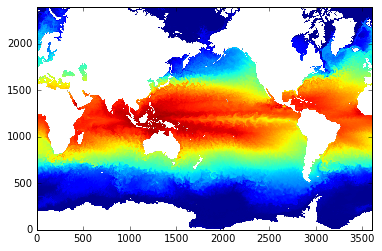

In [150]:
plt.imshow(SST[0].values, origin='bottom')

In [373]:
xs, xe = (0, 3500); ys, ye = (300, 2100)
lat = tlat[ys:ye, xs:xe].values
lon = tlon[ys:ye, xs:xe].values

In [374]:
print lon[:, 0]
print lon[:, -1]

[  0.05         0.05         0.05       ...,  13.17715633  13.24958734
  13.32242623]
[ 349.95        349.95        349.95       ...,  357.44650436  357.49176189
  357.53732722]


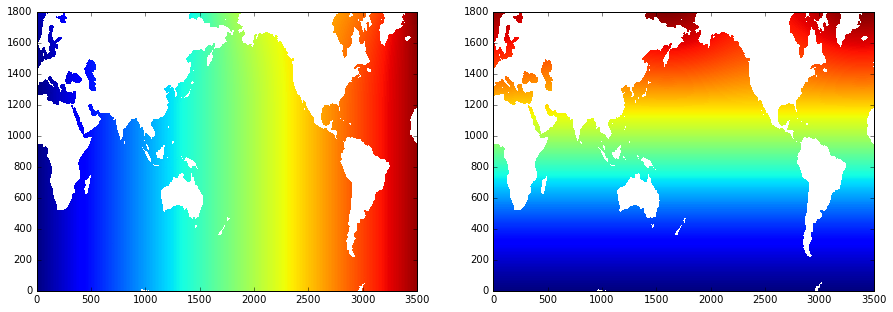

In [375]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.pcolormesh(np.ma.masked_invalid(lon))
ax2 = fig.add_subplot(122)
ax2.pcolormesh(np.ma.masked_invalid(lat))

In [376]:
lat_interp = p.interpolate_2d(np.ma.masked_invalid(lat))
lon_interp = p.interpolate_2d(np.ma.masked_invalid(lon))

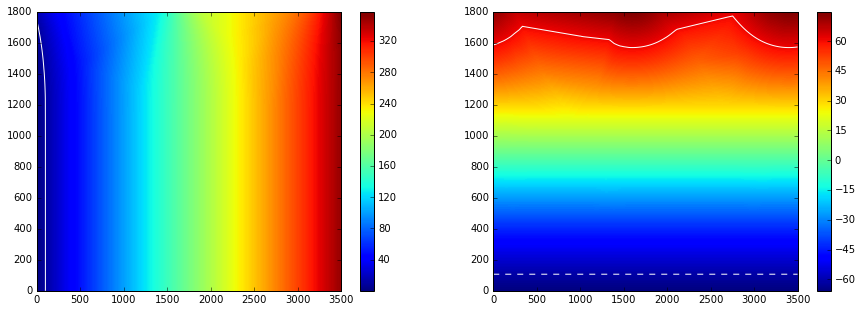

In [386]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(lon_interp))
ax1.contour(np.ma.masked_invalid(lon_interp), 
            levels=[10.05, 359.05], colors='w', lw=3)
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(lat_interp))
ax2.contour(np.ma.masked_invalid(lat_interp), 
            levels=[-61., 61.], colors='w', lw=3)
fig.colorbar(cax2)

In [245]:
# np.set_printoptions(threshold=np.nan)
print lon_interp[:, 120]
print lon_interp[:, -10]

[ 12.05        12.05        12.05       ...,  28.01341341  28.06680366
  28.12019391]
[ 359.05        359.05        359.05       ...,   11.7409953    11.81175059
   11.88291327]


In [213]:
np.isnan(lat_interp).any()

False

In [364]:
for j in range(lat_interp.shape[0]):
    for i in range(lat_interp.shape[1]):
        if np.isnan(lat_interp[j, i]):
            print j, i

In [365]:
for j in range(lon_interp.shape[0]):
    for i in range(lon_interp.shape[1]):
        if np.isnan(lon_interp[j, i]):
            print j, i

In [87]:
nany, nanx = (1594, 1516)
lat_interp[nany, nanx] = .5*(lat_interp[nany, nanx-1] + lat_interp[nany, nanx+1])
lon_interp[nany, nanx] = .5*(lon_interp[nany-1, nanx] + lon_interp[nany+1, nanx])

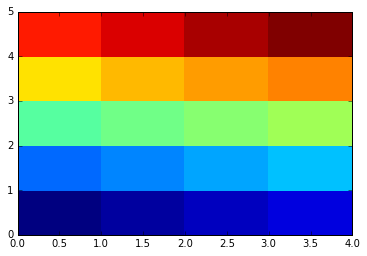

In [88]:
plt.pcolormesh(np.ma.masked_invalid(lat_interp[1592:1597, 1515:1519]))

In [43]:
poplat = xray.DataArray(lat_interp, dims=['nlat', 'nlon'], 
                                          coords={'nlat': SST.nlat.values[ys:ye], 'nlon': SST.nlon.values[xs:xe]}).to_dataset(name='lat')
poplon = xray.DataArray(lon_interp, dims=['nlat', 'nlon'], 
                                          coords={'nlat': SST.nlat.values[ys:ye], 'nlon': SST.nlon.values[xs:xe]}).to_dataset(name='lon')

In [32]:
poplat

<xarray.Dataset>
Dimensions:  (nlat: 1900, nlon: 3500)
Coordinates:
  * nlat     (nlat) int64 200 201 202 203 204 205 206 207 208 209 210 211 ...
  * nlon     (nlon) int64 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 ...
Data variables:
    lat      (nlat, nlon) float64 nan nan nan nan nan nan nan nan nan nan ...

In [388]:
y_new = np.arange(-61., 62.)
x_new = np.arange(9., 351.)
xx_new, yy_new = np.meshgrid(x_new, y_new)

In [367]:
print x_new

[   1.    2.    3. ...,  353.  354.  355.]


In [289]:
print yy_new
print xx_new

[[-61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61. -61.
  -61. -61. -61. -61. -61. -61.]
 [-60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60.
  -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60.
  -60. -60. -60. -60. -60. -60.

In [389]:
varname = 'SST'
T = SST.reset_coords(names=['ULONG', 'ULAT', 'TLONG', 'TLAT'], 
                     drop=True).copy()[:, ys:ye, xs:xe]
T_nlon = xray.DataArray(range(T.shape[2]), 
                                               dims=['nlon'],
                                               coords={'nlon': range(T.shape[2])})
T_nlat = xray.DataArray(range(T.shape[1]), 
                                               dims=['nlat'],
                                               coords={'nlat': range(T.shape[1])})
T.coords['nlon'] = T_nlon
T.coords['nlat'] = T_nlat
assert T.values.ndim == 3
assert lat_interp.ndim == 2
assert lon_interp.ndim == 2
    
#     original_coords = ds.stack(points=(meri, zon))['points']
original_coords = zip(lat_interp.ravel(), lon_interp.ravel())
#     original_coords_list = []
#     for i in original_coords.values:
#         original_coords_list += [i,]
newyx = zip(yy_new.ravel(), xx_new.ravel())
tree = cKDTree(newyx)
distance, index = tree.query(original_coords)

In [425]:
# print T
# print T.nlon.values
# print T.nlat.values

In [132]:
print len(newyx)

44157


In [390]:
newlabel = np.empty(len(index), dtype=tuple)
index_test = np.zeros_like(index)
for i in range(len(index)):
    index_test[i] = index[i]
    newlabel[i] = newyx[index[i]]

In [426]:
# newlabel

In [410]:
np.set_printoptions(threshold=100)
T[0]

<xarray.DataArray (nlat: 1800, nlon: 3500)>
array([[-1.35001945, -1.21154153, -1.1240865 , ..., -1.61892056,
        -1.61825371, -1.61551273],
       [-1.40849972, -1.25727534, -1.15148902, ..., -1.61849296,
        -1.61727035, -1.61434805],
       [-1.46040571, -1.30895054, -1.19169557, ..., -1.61840224,
        -1.61587417, -1.6127615 ],
       ..., 
       [ 8.15999889,  7.99492168,  7.93024111, ..., -0.24305791,
        -0.25183344, -0.25053322],
       [ 8.19622135,  8.18900681,  8.12222958, ..., -0.21963181,
        -0.23754826, -0.23152597],
       [ 8.34800243,  8.29051113,  8.17882729, ..., -0.18221867,
        -0.20069917, -0.1857232 ]])
Coordinates:
    time     float64 3.172e+04
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [412]:
t_coords = T[0].stack(points=('nlat', 'nlon')).reset_coords(names='time', drop=True)['points']
np.set_printoptions(threshold=100)
print t_coords.dims
print t_coords.coords
print t_coords
print t_coords.values.shape

('points',)
Coordinates:
  * points   (points) object (0, 0) (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) ...
<xarray.DataArray 'points' (points: 6300000)>
array([(0, 0), (0, 1), (0, 2), ..., (1799, 3497), (1799, 3498),
       (1799, 3499)], dtype=object)
Coordinates:
  * points   (points) object (0, 0) (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) ...
(6300000,)


In [392]:
da_index = xray.DataArray(index, 
                                               dims=t_coords.dims,
                                               coords=t_coords.coords)

da_label = xray.DataArray(newlabel, 
                                               dims=t_coords.dims,
                                               coords=t_coords.coords)

np.set_printoptions(threshold=100)
da_label

<xarray.DataArray (points: 6300000)>
array([(-61.0, 9.0), (-61.0, 9.0), (-61.0, 9.0), ..., (61.0, 350.0),
       (61.0, 350.0), (61.0, 350.0)], dtype=object)
Coordinates:
  * points   (points) object (0, 0) (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) ...

In [200]:
i = 0
while i < len(da_label)/100:
    print da_label.values[i]
    i += 10

(-61.0, 1.0)
(-61.0, 1.0)
(-61.0, 2.0)
(-61.0, 3.0)
(-61.0, 4.0)
(-61.0, 5.0)
(-61.0, 6.0)
(-61.0, 7.0)
(-61.0, 8.0)
(-61.0, 9.0)
(-61.0, 10.0)
(-61.0, 11.0)
(-61.0, 12.0)
(-61.0, 13.0)
(-61.0, 14.0)
(-61.0, 15.0)
(-61.0, 16.0)
(-61.0, 17.0)
(-61.0, 18.0)
(-61.0, 19.0)
(-61.0, 20.0)
(-61.0, 21.0)
(-61.0, 22.0)
(-61.0, 23.0)
(-61.0, 24.0)
(-61.0, 25.0)
(-61.0, 26.0)
(-61.0, 27.0)
(-61.0, 28.0)
(-61.0, 29.0)
(-61.0, 30.0)
(-61.0, 31.0)
(-61.0, 32.0)
(-61.0, 33.0)
(-61.0, 34.0)
(-61.0, 35.0)
(-61.0, 36.0)
(-61.0, 37.0)
(-61.0, 38.0)
(-61.0, 39.0)
(-61.0, 40.0)
(-61.0, 41.0)
(-61.0, 42.0)
(-61.0, 43.0)
(-61.0, 44.0)
(-61.0, 45.0)
(-61.0, 46.0)
(-61.0, 47.0)
(-61.0, 48.0)
(-61.0, 49.0)
(-61.0, 50.0)
(-61.0, 51.0)
(-61.0, 52.0)
(-61.0, 53.0)
(-61.0, 54.0)
(-61.0, 55.0)
(-61.0, 56.0)
(-61.0, 57.0)
(-61.0, 58.0)
(-61.0, 59.0)
(-61.0, 60.0)
(-61.0, 61.0)
(-61.0, 62.0)
(-61.0, 63.0)
(-61.0, 64.0)
(-61.0, 65.0)
(-61.0, 66.0)
(-61.0, 67.0)
(-61.0, 68.0)
(-61.0, 69.0)
(-61.0, 70.0)
(-61.0, 71.0)
(-

In [393]:
np.set_printoptions(threshold=100)

# Nt = T.shape[0]
Nt = 1
da_numpy = np.zeros((Nt, len(yy_new[:, 0]), len(xx_new[0, :])))
for t in range(Nt):
    Ti = T[t].stack(points=('nlat', 'nlon')).reset_coords(names='time', drop=True).copy()
    print Ti.shape
    Ti.coords['index'] = da_index
    Ti.coords['label'] = da_label
#     print type(da_label)
    Ti_grouped = Ti.groupby('label').mean().to_dataset(name=varname)
#     print Ti_grouped

    arrays = [[i for item in yy_new[:, 0] for i in repeat(item, len(xx_new[0, :]))], 
                  np.tile(xx_new[0, :], len(yy_new[:, 0]))]
    tuples = list(zip(*arrays))
    Ti_panda_index = pd.MultiIndex.from_tuples(tuples, names=['lat', 'lon'])
    Ti_panda = pd.Series(Ti_grouped[varname], index=Ti_panda_index)
    Ti_panda_unstacked = Ti_panda.unstack(level=-1)
    da_numpy[t] = Ti_panda_unstacked.values
    
da = xray.DataArray(da_numpy, dims=['day', 'lat', 'lon'], 
                                      coords={'day': range(Nt), 'lat': yy_new[:, 0], 'lon': xx_new[0, :]}).to_dataset(name=varname)

(6300000,)


In [394]:
da

<xarray.Dataset>
Dimensions:  (day: 1, lat: 123, lon: 342)
Coordinates:
  * lat      (lat) float64 -61.0 -60.0 -59.0 -58.0 -57.0 -56.0 -55.0 -54.0 ...
  * lon      (lon) float64 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 ...
  * day      (day) int64 0
Data variables:
    SST      (day, lat, lon) float64 -0.8762 -0.1228 -0.1652 -0.1903 -0.1983 ...

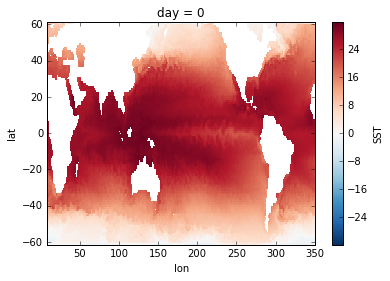

In [395]:
da.SST[0].plot()

In [421]:
def pop_orthogonalgrid(ds, lat, lon, newlat, newlon, mask, 
                       varname='SST', xs=0, xe=3600, ys=0, ye=2400, 
                       nroll=-1100, cython=True):
    """
    Parameters
    --------------
    ds : xarray.Dataset
        raw data
    lat : numpy.array
        raw latitude
    lon: numpy.array
        raw longitude
    newlat: numpy.array
        latitude coordinate to regrid on
    newlon: numpy.array
        longitude coordinate to regrid on
        
    Returns
    -------------
    da : xarray.Dataset
        new dataset with labels added
    """
    data = ds[varname].where(mask).roll(nlon=nroll)
    assert data.values.ndim == 3
    assert lat.ndim == 2
    assert lon.ndim == 2
    assert np.isnan(lat).any() == False
    assert np.isnan(lon).any() == False
    
    T = data.reset_coords(names=['ULONG', 'ULAT', 'TLONG', 'TLAT'], 
                         drop=True).copy()[:, ys:ye, xs:xe]
    T_nlon = xray.DataArray(range(T.shape[2]), 
                                                   dims=['nlon'],
                                                   coords={'nlon': range(T.shape[2])})
    T_nlat = xray.DataArray(range(T.shape[1]), 
                                                   dims=['nlat'],
                                                   coords={'nlat': range(T.shape[1])})
    T.coords['nlon'] = T_nlon
    T.coords['nlat'] = T_nlat

    #     original_coords = ds.stack(points=(meri, zon))['points']
    original_coords = zip(lat_interp.ravel(), lon_interp.ravel())
    #     original_coords_list = []
    #     for i in original_coords.values:
    #         original_coords_list += [i,]
    newyx = zip(newlat.ravel(), newlon.ravel())
    tree = cKDTree(newyx)
    distance, index = tree.query(original_coords)
    
    newlabel = np.empty(len(index), dtype=tuple)
    index_test = np.zeros_like(index)
    for i in range(len(index)):
        index_test[i] = index[i]
        newlabel[i] = newyx[index[i]]
    
    t_coords = T[0].stack(points=('nlat', 'nlon')).reset_coords(names='time', drop=True)['points']
    da_index = xray.DataArray(index, 
                                                   dims=t_coords.dims,
                                                   coords=t_coords.coords)

    da_label = xray.DataArray(newlabel, 
                                                   dims=t_coords.dims,
                                                   coords=t_coords.coords)
    
    Nt = T.shape[0]
    da_numpy = np.zeros((Nt, len(newlat[:, 0]), len(newlon[0, :])))
    for t in range(Nt):
        Ti = T[t].stack(points=('nlat', 'nlon')).reset_coords(names='time', drop=True).copy()
        print Ti.shape
        Ti.coords['index'] = da_index
        Ti.coords['label'] = da_label
    #     print type(da_label)
        Ti_grouped = Ti.groupby('label').mean().to_dataset(name=varname)
    #     print Ti_grouped

        arrays = [[i for item in newlat[:, 0] for i in repeat(item, len(newlon[0, :]))], 
                      np.tile(newlon[0, :], len(newlat[:, 0]))]
        tuples = list(zip(*arrays))
        Ti_panda_index = pd.MultiIndex.from_tuples(tuples, names=['lat', 'lon'])
        Ti_panda = pd.Series(Ti_grouped[varname], index=Ti_panda_index)
        Ti_panda_unstacked = Ti_panda.unstack(level=-1)
        da_numpy[t] = Ti_panda_unstacked.values

    da = xray.DataArray(da_numpy, dims=['day', 'lat', 'lon'], 
                                          coords={'day': range(Nt), 'lat': yy_new[:, 0], 'lon': xx_new[0, :]}).to_dataset(name=varname)
    
    return da

In [422]:
SST_gridded = pop_orthogonalgrid(ds, lat_interp, lon_interp, yy_new, xx_new, mask, xe=3500, ys=300, ye=2100)

(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)
(6300000,)


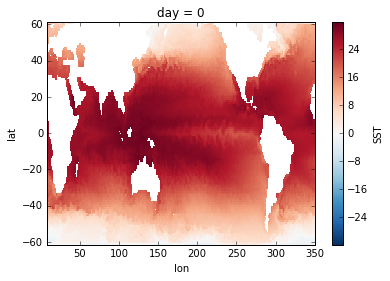

In [423]:
SST_gridded.SST[0].plot()

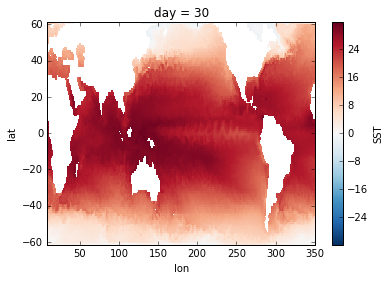

In [424]:
SST_gridded.SST[30].plot()